# Vivarium interface basics

## Overview
This notebook introduces the Vivarium interface protocol by working through a simple, qualitative example of transcription/translation, and iterating on model design to add more complexity.

**Note:** The included examples often skirt best coding practice in favor of simplicity. See Vivarium templates on github for better starting examples: https://github.com/vivarium-collective/vivarium-template

In [1]:
# # install vivarium libraries
# %%capture
# !pip install vivarium-core==0.2.7


In [2]:
# Imports and Notebook Utilities
import os
import copy
import pylab as plt
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import matplotlib

# Process, Deriver, and Composer base classes
from vivarium.core.process import (
    Process, 
    Deriver,
    Composer)
from vivarium.core.registry import process_registry

# helper functions for composition
from vivarium.core.composition import (
    simulate_process,
    process_in_experiment,
    composer_in_experiment,
    composite_in_experiment)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables, save_fig_to_dir)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

AVOGADRO = constants.N_A * 1 / units.mol

store_cmap = matplotlib.cm.get_cmap('Dark2')
dna_color = matplotlib.colors.to_rgba(store_cmap(0))
rna_color = matplotlib.colors.to_rgba(store_cmap(1))
protein_color = matplotlib.colors.to_rgba(store_cmap(2)) 
global_color = matplotlib.colors.to_rgba(store_cmap(7))                             
store_colors = {
    'DNA': dna_color, 
    'DNA\n(counts)': dna_color, 
    'DNA\n(mg/mL)': dna_color, 
    'mRNA': rna_color,
    'mRNA\n(counts)': rna_color,
    'mRNA\n(mg/mL)': rna_color,
    'Protein': protein_color,
    'Protein\n(mg/mL)': protein_color,
    'global': global_color}
                       
# plotting configurations
topology_plot_config = {
    'settings': {
        'coordinates': {
            'Tl': (-1,0),
            'Tx': (-1,-1),
            'Protein': (1,0),
            'mRNA': (1,-1),
            'DNA': (1,-2),
        },
        'node_distance': 3.0,
        'process_color': 'k',
        'store_colors': store_colors,
        'graph_format': 'vertical',
        'color_edges': False}, 
    'out_dir': 'out/'}

plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': 'out'}

# **1. Make a Process: minimal transcription**

Transcription is the biological process by which RNA is synthesized from a DNA template.
Here, we define a model with a single mRNA species, $C$, transcribed from a single gene, $G$, at transcription rate $k_{tsc}$.
RNA also degrades at rate $k_{deg}$.

This can be represented by a chemical reaction network with the form:

<br>
<center>
$Gene_{G} \xrightarrow[]{k_{tsc}} Gene_{G} + RNA_{C} $ <br><br>
$RNA_{C} \xrightarrow[]{k_{deg}} \emptyset$
</center>

Which is written as the difference equation:

<br>
<center>
$\Delta RNA_{C} = (k_{tsc}[Gene_{G}] - k_{deg}[RNA_{C}]) \Delta t $ <br>
</center>

## Vivarium's basic elements
**Processes** can implement any kind of dynamical model - dynamic flux balance analysis, differential equation, stochastic process, Boolean logic, etc. \
**Stores** are databases of state variables read by the Processes, with methods for applying each Processes' updates.

<table><tr>
<td> <img src="images/process.png" alt="Drawing" style="width: 600;"/> </td>
<td> <img src="images/store.png" alt="Drawing" style="width: 600;"/> </td>
</tr></table>

### Process interface protocol
If standard modeling formats are an "HTML" for systems biology, we need an "interface protocol" such as TCP/IP serves for the internet -- a protocol for connecting separate systems into a complex and open-ended network that anyone can contribute to.

Making a dynamical model into a Vivarium Process requires the following protocol:
1. A *constructor* that accepts parameters and configures the model.
2. A *ports_schema* that declares the ports and their schema.
3. A *next_update* that runs the model and returns an update.

### Constructor
* `default` parameters are used in absense of an other provided parameters.
* The constructor's `parameters` arguments overrides the `default` parameters.

```python
class Tx(Process):
 
    defaults = {
        'ktsc': 1e-2,
        'kdeg': 1e-3}
    
    def __init__(self, parameters=None):
        super().__init__(parameters)
```

### Ports Schema
* Ports are the connections by which Process are wired to Stores. 
* `ports_schema` declares the ports, the variables that go through them, and how those variables operate.
* Here, `Tx` declares a port for `mRNA` with variable `C`, and a port for `DNA` with variable `G`.

```python
def ports_schema(self):
    return {
        'mRNA': {
            'C': {
                '_default': 0.0,
                '_updater': 'accumulate',
                '_divider': 'set',
                '_properties': {
                    'mw': 111.1 units.g / units.mol}},
        'DNA': {  
            'G': {
                '_default': 1.0}}
```

#### Advanced ports_schema

* dictionary comprehensions are useful for declaring schema for configured variables.

```python
def ports_schema(self):
    molecule_schema = {
        '_default': 0.0,
        '_emit': True}
    
    return {
        'molecules': {
            mol_id: molecule_schema 
            for mol_id in self.parameters['molecules']}}
```

#### Advanced ports_schema

* Schema methods can also be declared by passing in functions.
* The asymmetric_division divider makes molecules in the 'front' go to one daughter cell upon division, and those in the 'back' go to the other daughter.

```python
def asymmetric_division(value, topology):
    if 'front' in topology:
        return [value, 0.0]
    elif 'back' in topology:
        return [0.0, value]

def ports_schema(self):
    return {
        'front': {
            'molecule': {
                '_divider': {
                    'divider': asymmetric_division,
                    'topology': {'front': ('molecule',)},
                }}},
        'back': {
            'molecule': {
                '_divider': {
                    'divider': asymmetric_division,
                    'topology': {'back': ('molecule',)},
                }}}}
```

### Initial State
* Each Process MAY provide an `initial_state` method. This can be retrieved, reconfigured, and passed into a simulation.
* If left empty, a simulation initializes at the `'_default'` values.

```python
def initial_state(self, config):
    return {
        'DNA': {'G': 1.0},
        'mRNA': {'C': 0.0}}
```

### Update Method
* **Retrieve** the state variables through the ports.
* **Run** the model for the timestep’s duration.
* **Return** an update to the state variable through the ports.

```python
def next_update(self, states, timestep):

    # Retrieve
    G = states['DNA']['G']
    C = states['mRNA']['C']

    # Run
    dC = (self.ktsc * G - self.kdeg * C) * timestep

    # Return
    return {
        'mRNA': {
            'C': dC}}
```

## Tx: a deterministic transcription process

According to [BioNumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=3&id=100043), the concentration of DNA in an *E. coli* cell is on the order of 11-18 mg/mL. The concentration of RNA is 75-120 mg/ml.

In [3]:
class Tx(Process):
    
    defaults = {
        'ktsc': 1e-2,
        'kdeg': 1e-3}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        
    def ports_schema(self):
        return {
            'DNA': {  
                'G': {
                    '_default': 10 * units.mg / units.mL,         
                    '_updater': 'accumulate',
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 100 * units.mg / units.mL,
                    '_updater': 'accumulate',
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        G = states['DNA']['G']
        C = states['mRNA']['C']
        dC = (self.parameters['ktsc'] * G - self.parameters['kdeg'] * C) * timestep
        return {
            'mRNA': {
                'C': dC}}

### plot Tx topology

Writing out/tx_topology.pdf


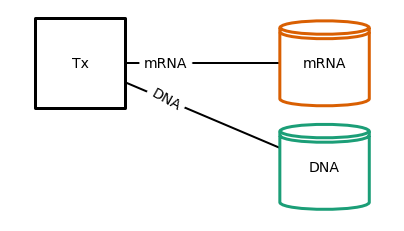

In [4]:
fig = plot_topology(Tx(), filename='tx_topology.pdf', **topology_plot_config)


### run Tx

In [5]:
# tsc configuration
tx_config = {'time_step': 10}
tx_sim_settings = {
    'experiment_id': 'TX'}
tx_initial_state = {
    'mRNA': {'C': 0.0 * units.mg/units.mL}}
tx_plot_config = {
    'variables': [
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        }, 
        {
            'variable': ('DNA', ('G', 'milligram / milliliter')),
            'color': store_colors['DNA']
        }],
    'filename': 'tx_output.pdf',
    **plot_var_config}


Experiment ID: TX
Created: 03/12/2021 at 12:10:19
Completed in 0.211423 seconds
Writing out/tx_output.pdf


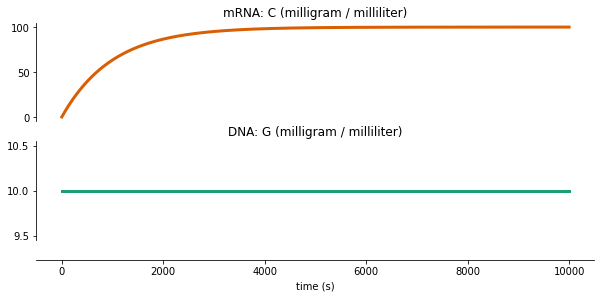

In [6]:
# initialize
tx_process = Tx(tx_config)

# make the experiment
tx_exp = process_in_experiment(
    tx_process, tx_sim_settings, tx_initial_state)

# run
tx_exp.update(10000)

# retrieve the data as a timeseries
tx_output = tx_exp.emitter.get_timeseries()

# plot
fig = plot_variables(tx_output,  **tx_plot_config)

## Tl: a deterministic translation process

Translation is the biological process by which protein is synthesized with an mRNA template.
Here, we define a model with a single protein species, $Protein_{X}$, transcribed from a single gene, $RNA_{C}$, at translation rate $k_{trl}$.
Protein also degrades at rate $k_{deg}$.

This can be represented by a chemical reaction network with the form:
* $RNA_{C} \xrightarrow[]{k_{trl}} RNA_{C} + Protein_{X} $ 
* $Protein_{X} \xrightarrow[]{k_{deg}} \emptyset$

According to [BioNumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=3&id=100043), the concentration of RNA in an *E. coli* cell is on the order of 75-120 mg/ml. The concentration of protein is 200-320 mg/ml.


In [7]:
class Tl(Process):

    defaults = {
        'ktrl': 5e-4,
        'kdeg': 5e-5}

    def ports_schema(self):
        return {
            'mRNA': {
                'C': {
                    '_default': 100 * units.mg / units.mL,
                    '_divider': 'split',
                    '_emit': True}},
            'Protein': {
                'X': {
                    '_default': 200 * units.mg / units.mL,
                    '_divider': 'split',
                    '_emit': True}}}

    def next_update(self, timestep, states):
        C = states['mRNA']['C']
        X = states['Protein']['X']
        dX = (self.parameters['ktrl'] * C - self.parameters['kdeg'] * X) * timestep
        return {
            'Protein': {
                'X': dX}}
    

### run Tl

In [8]:
# trl configuration
tl_config = {'time_step': 10}
tl_sim_settings = {'experiment_id': 'TL'}
tl_initial_state = {
    'Protein': {'X': 0.0 * units.mg / units.mL}}
tl_plot_config = {
    'variables': [
        {
            'variable': ('Protein', ('X', 'milligram / milliliter')),
            'color': store_colors['Protein']
        },
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        },  
        ],
    'filename': 'tl_output.pdf',
    **plot_var_config}


Experiment ID: TL
Created: 03/12/2021 at 12:10:20
Completed in 0.225975 seconds
Writing out/tl_output.pdf


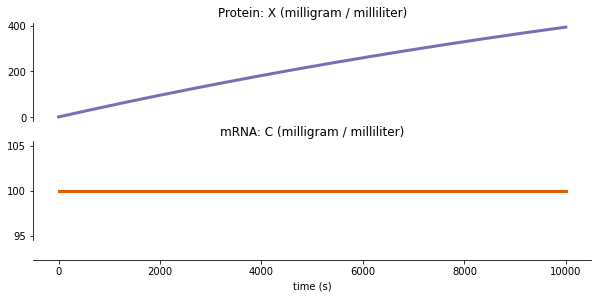

In [9]:
# initialize
tl_process = Tl(tl_config)

# make the experiment
tl_exp = process_in_experiment(
    tl_process, tl_sim_settings, tl_initial_state)

# run
tl_exp.update(10000)

# retrieve the data as a timeseries
tl_output = tl_exp.emitter.get_timeseries()

# plot
fig = plot_variables(tl_output,  **tl_plot_config)

# **2. Make a Composite**

A **Composite** is a set of Processes and Stores. Vivarium constructs the Stores from the Processes's port_schema methods and wires them up as instructed by a **Topology**. The only communication between Processes is through variables in shared Stores.

<center><img src="images/composite.png" width=600/></center>

## TxTl: a transcription/translation composite

We demonstrate composition by combining the `Tx` and `Tl` processes.

### Composition protocol

Composers, which combine processes into composites are implemented with the protocol:
1. A *constructor* that accepts configuration data, which can override the consituent Processes' default parameters.
1. A *generate_processes* method that constructs the Processes, passing model parameters as needed.
2. A *generate_topology* method that returns the Topology definition which tells Vivarium how to wire up the Processes to Stores.

#### composite constructor

```python
class TxTl(Composer):
    
    defaults = {
        'Tx': {
            'ktsc': 1e-2},
        'Tl': {
            'ktrl': 1e-3}}
    
    def __init__(self, config=None):
        super().__init__(config)
```

#### generate topology
* Here, `generate_topology()` returns the Topology definition that wires these Processes together with 3 Stores, one of them shared.

```python
def generate_topology(self, config):
    return {
        'Tx': {
            'DNA': ('DNA',),     # connect TSC's 'DNA' Port to a 'DNA' Store
            'mRNA': ('mRNA',)},  # connect TSC's 'mRNA' Port to a 'mRNA' Store
        'Tl': {
            'mRNA': ('mRNA',),   # connect TRL's 'mRNA' Port to the same 'mRNA' Store
            'Protein': ('Protein',)}}
```

#### advanced generate topology

* **embedding in a hierarchy**: to connect to sub-stores in a hierarchy, declare the path through each substore, as done to 'lipids'.
    * To connect to supra-stores use `'..'` for each level up, as done to `'external'`.
* **splitting ports**: One port can connect to multiple stores by specifying the path for each variable, as is done to `'transport'`.
    * This can be used to re-map variable names, for integration of different models.

```python
def generate_topology(config):
    return {
        'process_1': {
            'lipids': ('organelle', 'membrane', 'lipid'),
            'external': ('..', 'environment'),
            'transport': {
                'glucose_external': ('external', 'glucose'),
                'glucose_internal': ('internal', 'glucose'),
            }
        }}
```

### TxTl Composer

In [10]:
class TxTl(Composer):
    
    defaults = {
        'Tx': {'time_step': 10},
        'Tl': {'time_step': 10}}

    def generate_processes(self, config):
        return {
            'Tx': Tx(config['Tx']),
            'Tl': Tl(config['Tl'])}

    def generate_topology(self, config):
        return {
            'Tx': {
                'DNA': ('DNA',),
                'mRNA': ('mRNA',)},
            'Tl': {
                'mRNA': ('mRNA',),
                'Protein': ('Protein',)}}
    

### plot TxTl topology

Writing out/txtl_topology.pdf


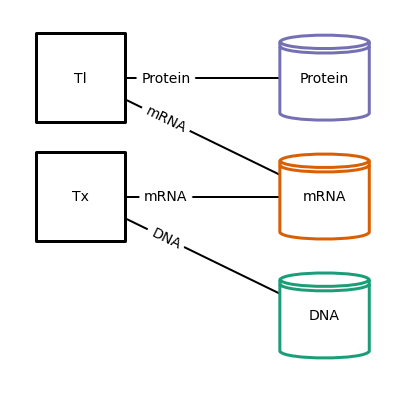

In [11]:
txtl_topology_plot_config = copy.deepcopy(topology_plot_config)
txtl_topology_plot_config['settings']['node_distance'] = 2
fig = plot_topology(TxTl(), filename='txtl_topology.pdf', **topology_plot_config)

### run TxTl

In [12]:
# tsc_trl configuration
txtl_config = {}
txtl_exp_settings = {'experiment_id': 'TXTL'}
txtl_plot_config = {
    'variables':[
        {
            'variable': ('Protein', ('X', 'milligram / milliliter')),
            'color': store_colors['Protein']
        },
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        },
        {
            'variable': ('DNA', ('G', 'milligram / milliliter')), 
            'color': store_colors['DNA']
        },
    ],
    'filename': 'txtl_output.pdf',
    **plot_var_config}
tl_initial_state = {
    'mRNA': {'C': 0.0 * units.mg / units.mL},
    'Protein': {'X': 0.0 * units.mg / units.mL}}


Experiment ID: TXTL
Created: 03/12/2021 at 12:10:21
Completed in 0.411037 seconds
Writing out/txtl_output.pdf


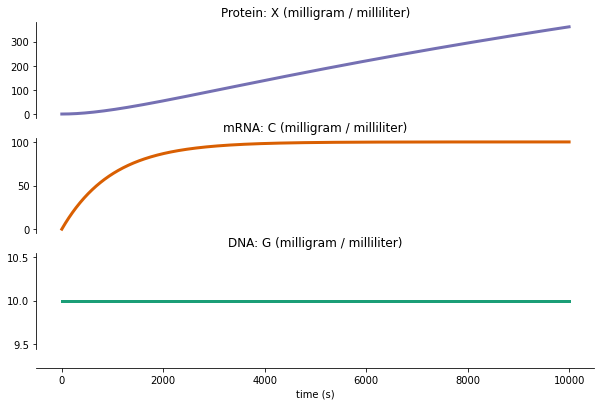

In [13]:
# construct TxTl
txtl_composite = TxTl(txtl_config)

# make the experiment
txtl_experiment = composer_in_experiment(
    txtl_composite, txtl_exp_settings, tl_initial_state)

# run it and retrieve the data that was emitted to the simulation log
txtl_experiment.update(10000)
txtl_output = txtl_experiment.emitter.get_timeseries()

# plot the output
fig = plot_variables(txtl_output, **txtl_plot_config)

# **3. Adding Complexity** 

Process modularity allows modelers to iterate on model design by swapping out different models.
We demonstrated this by replacing the deterministic Transcription Process with a Stochastic Transcription Process. 

Stochastic transcription requires variable timesteps, which Vivarium accomodates with multi-timestepping.
<center><img src="images/dynamics.png" width=900/></center>

## StochasticTx: a stochastic transcription process
This process uses the [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm) in its `next_update()` method.

In [36]:
stoch_exp_settings = {
    'settings': {
        'experiment_id': 'stochastic_txtl'},
    'initial_state': {
            'DNA\n(counts)': {
                'G': 1.0
            },
            'mRNA\n(counts)': {
                'C': 0.0
            },
            'Protein\n(mg/mL)': {
                'X': 0.0 * units.mg / units.mL
            }}}


stoch_plot_config = {
    'variables':[
        {
            'variable': ('Protein\n(mg/mL)', ('X', 'milligram / milliliter')), 
            'color': store_colors['Protein'],
            'display': 'Protein: X (mg/mL)'}, 
        {
            'variable': ('mRNA\n(mg/mL)', ('C', 'milligram / milliliter')), 
            'color': store_colors['mRNA'],
            'display': 'mRNA: C (mg/mL)'}, 
        {
            'variable': ('DNA\n(counts)', 'G'), 
            'color': store_colors['DNA'],
            'display': 'DNA: G (counts)'}, 
    ],
    'filename': 'stochastic_txtl_output.pdf',
    **plot_var_config}

In [37]:
class StochasticTx(Process):

    defaults = {
        'ktsc': 1e0,
        'kdeg': 1e-3}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.ktsc = self.parameters['ktsc']
        self.kdeg = self.parameters['kdeg']
        self.stoichiometry = np.array([[0, 1], [0, -1]])
        self.time_left = None
        self.event = None

        # initialize the next timestep
        initial_state = self.initial_state()
        self.calculate_timestep(initial_state)
        
    def initial_state(self, config=None):
        return {
            'DNA': {
                'G': 1.0
            },
            'mRNA': {
                'C': 1.0
            }
        }
    
    def ports_schema(self):
        return {
            'DNA': {
                'G': {
                    '_default': 1.0,
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 1.0,
                    '_emit': True}}}

    def calculate_timestep(self, states):
        # retrieve the state values
        g = states['DNA']['G']
        c = states['mRNA']['C']

        array_state = np.array([g, c])

        # Calculate propensities
        propensities = [
            self.ktsc * array_state[0], self.kdeg * array_state[1]]
        prop_sum = sum(propensities)

        # The wait time is distributed exponentially
        self.calculated_timestep = np.random.exponential(scale=prop_sum)
        return self.calculated_timestep

    def next_reaction(self, x):
        """get the next reaction and return a new state"""

        propensities = [self.ktsc * x[0], self.kdeg * x[1]]
        prop_sum = sum(propensities)

        # Choose the next reaction
        r_rxn = np.random.uniform()
        i = 0
        for i, _ in enumerate(propensities):
            if r_rxn < propensities[i] / prop_sum:
                # This means propensity i fires
                break
        x += self.stoichiometry[i]
        return x

    def next_update(self, timestep, states):

        if self.time_left is not None:
            if timestep >= self.time_left:
                event = self.event
                self.event = None
                self.time_left = None
                return event

            self.time_left -= timestep
            return {}

        # retrieve the state values, put them in array
        g = states['DNA']['G']
        c = states['mRNA']['C']
        array_state = np.array([g, c])

        # calculate the next reaction
        new_state = self.next_reaction(array_state)

        # get delta mRNA
        c1 = new_state[1]
        d_c = c1 - c

        update = {
            'mRNA': {
                'C': d_c}}

        if self.calculated_timestep > timestep:
            # didn't get all of our time, store the event for later
            self.time_left = self.calculated_timestep - timestep
            self.event = update
            return {}

        # return an update
        return {
            'mRNA': {
                'C': d_c}}


Experiment ID: stochastic_txtl
Created: 03/12/2021 at 12:13:53
Completed in 0.457430 seconds


### plot variable timesteps

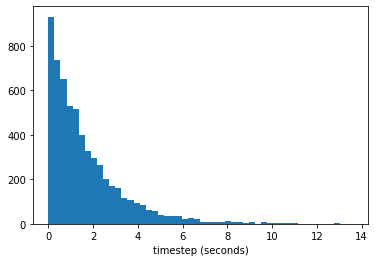

In [39]:
stoch_tx_process = StochasticTx(tx_config)
stoch_tx_exp = process_in_experiment(stoch_tx_process, **stoch_exp_settings)
stoch_tx_exp.update(10000)
stoch_tx_output = stoch_tx_exp.emitter.get_timeseries()



# calculate the timesteps
times = stoch_tx_output['time']
timesteps = [] 
for x, y in zip(times[0::], times[1::]): 
#     if y-x != 1.0:
        timesteps.append(y-x) 
        
fig = plt.hist(timesteps, 50)
plt.xlabel('timestep (seconds)')
plt.savefig('out/stochastic_timesteps.pdf')


## Auxiliary Processes
* Connecting different Processes may require addition 'helper' Processes to make conversions and adapt their unique requirements different values.
* Derivers are a subclass of Process that runs after the other dynamic Processes and derives some states from others.

A **concentration deriver** convert the counts of the stochastic process to concentrations. This is available in the `process_registry`
```python
concentrations_deriver = process_registry.access('concentrations_deriver')
```

## Combining stochastic Tx with deterministic Tl

In [18]:
# configuration data
mw_config = {'C': 1e8 * units.g / units.mol}

In [19]:
  
class StochasticTxTl(Composer):
    defaults = {
        'stochastic_Tx': {},
        'Tl': {'time_step': 1},
        'concs': {
            'molecular_weights': mw_config}}
    
    def generate_processes(self, config):
        counts_to_concentration = process_registry.access('counts_to_concentration')
        return {
            'stochastic\nTx': StochasticTx(config['stochastic_Tx']),
            'Tl': Tl(config['Tl']),
            'counts\nto\nmg/mL': counts_to_concentration(config['concs'])}

    def generate_topology(self, config):
        return {
            'stochastic\nTx': {
                'DNA': ('DNA\n(counts)',),
                'mRNA': ('mRNA\n(counts)',)
            },
            'Tl': {
                'mRNA': ('mRNA\n(mg/mL)',),
                'Protein': ('Protein\n(mg/mL)',)
            },
            'counts\nto\nmg/mL': {
                'global': ('global',),
                'input': ('mRNA\n(counts)',),
                'output': ('mRNA\n(mg/mL)',)
            }}
    

### plot StochasticTxTl topology

Writing out/stochastic_txtl_topology.pdf


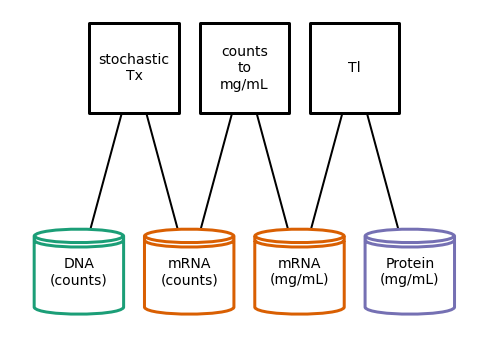

In [20]:
# plot topology after merge
stochastic_topology_plot_config = copy.deepcopy(topology_plot_config)
stochastic_topology_plot_config['settings']['graph_format'] = 'horizontal'
stochastic_topology_plot_config['settings']['coordinates'] = {
    'stochastic\nTx': (1.5, 1),
    'counts\nto\nmg/mL': (2.5, 1),
    'Tl': (3.5, 1),
    'DNA\n(counts)': (1,-1),
    'mRNA\n(counts)': (2,-1),
    'mRNA\n(mg/mL)': (3,-1),
    'Protein\n(mg/mL)': (4,-1)}
stochastic_topology_plot_config['settings']['remove_nodes'] = ['global']
stochastic_topology_plot_config['settings']['show_ports'] = False
stochastic_topology_plot_config['settings']['node_distance'] = 2.5

stochastic_txtl = StochasticTxTl()
fig = plot_topology(
    stochastic_txtl, 
    filename='stochastic_txtl_topology.pdf', 
    **stochastic_topology_plot_config)

### run StochasticTxTl


Experiment ID: stochastic_txtl
Created: 03/12/2021 at 12:10:23
Completed in 0.828192 seconds
Writing out/stochastic_txtl_output.pdf


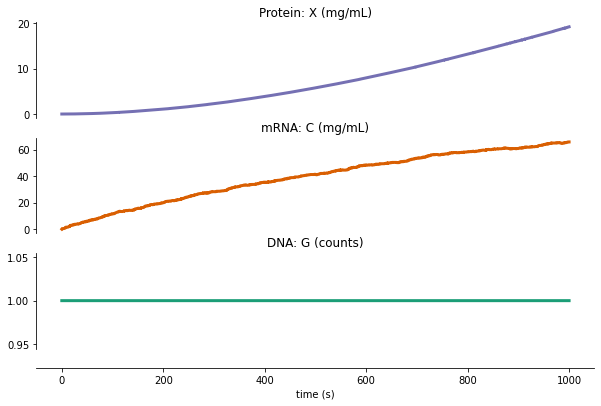

In [21]:
# make the experiment
stoch_experiment = composer_in_experiment(stochastic_txtl, **stoch_exp_settings)

# simulate and retrieve the data
stoch_experiment.update(1000)
stochastic_txtl_output = stoch_experiment.emitter.get_timeseries()

# plot output
fig = plot_variables(stochastic_txtl_output, **stoch_plot_config)

# **4. Growth and Division**

We here extend the Transcription/Translation model with division. This require many instances of the processes to run simultaneously in a single simulation. To support such phenomena, Vivarium adopts an agent-based modeling bigraphical formalism, with embedded compartments that can spawn new compartments during runtime. 

<!-- <center><img src="images/tsc_trl_divide.png" width=700/></center> -->

## Hierarchical Embedding

To support this requirement, Processes can be embedded in a hierarchical representation of embedded compartments.
Vivarium uses a bigraph formalism -- a graph with embeddable nodes that can be placed within other nodes.

<center><img src="images/embedding.png" width=900/></center>

## Hierarchy updates

The structure of a hierarchy has its own type of constructive dynamics with formation/destruction, merging/division, engulfing/expelling of compartments

<center><img src="images/constructive.png" width=900/></center>

In [22]:
# add imported division processes
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision
from vivarium.processes.growth_rate import GrowthRate

TIMESTEP = 10


class TxTlDivision(Composer):
    defaults = {
        'stochastic_Tx': {'time_step': TIMESTEP},
        'Tl': {'time_step': TIMESTEP},
        'concs': {
            'molecular_weights': mw_config},
        'growth': {
            'time_step': 1,
            'default_growth_rate': 0.0005,
            'default_growth_noise': 0.001,
            'variables': ['volume']},
        'agent_id': np.random.randint(0, 100),
        'divide_condition': {
            'threshold': 2.5 * units.fL},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple(),
        '_schema': {
            'concs': {
                'input': {'C': {'_divider': 'binomial'}},
                'output': {'C': {'_divider': 'set'}},
            }
        }
    }

    def generate_processes(self, config):
        counts_to_concentration = process_registry.access('counts_to_concentration')
        division_config = dict(
            daughter_path=config['daughter_path'],
            agent_id=config['agent_id'],
            composer=self)

        return {
            'stochastic_Tx': StochasticTx(config['stochastic_Tx']),
            'Tl': Tl(config['Tl']),
            'concs': counts_to_concentration(config['concs']),
            'growth': GrowthRate(config['growth']),
            'divide_condition': DivideCondition(config['divide_condition']),
            'division': MetaDivision(division_config),
        }

    def generate_topology(self, config):
        return {
            'stochastic_Tx': {
                'DNA': ('DNA',),
                'mRNA': ('RNA_counts',)
            },
            'Tl': {
                'mRNA': ('RNA',),
                'Protein': ('Protein',)
            },
            'concs': {
                'global': ('boundary',),
                'input': ('RNA_counts',),
                'output': ('RNA',)
            },
            'growth': {
                'variables': ('boundary',),
                'rates': ('rates',)
            },
            'divide_condition': {
                'variable': ('boundary', 'volume',),
                'divide': ('boundary', 'divide',)},
            'division': {
                'global': ('boundary',),
                'agents': config['agents_path']}
        }

  

## Colony-level processes

In [23]:
from vivarium.library.units import Quantity

def calculate_volume(value, path, node):
    if isinstance(node.value, Quantity) and node.units == units.fL:
        return value + node.value
    else:
        return value
    
class ColonyVolume(Deriver):
    defaults = {
        'from_path': ('..', '..', 'agents')}
    def ports_schema(self):
        return {
            'global': {
                'volume': {
                    '_default': 1.0 * units.fL,
                    '_updater': 'set',
                    '_emit': True}}}
    def next_update(self, timestep, states):
        return {
            'global': {
                'volume': {
                    '_reduce': {
                        'reducer': calculate_volume,
                        'from': self.parameters['from_path'],
                        'initial': 0.0 * units.fL}}}}

In [24]:
# configure hierarchy
# agent config
agent_id = '0'
agent_config = {'agent_id': agent_id}

# environment config
env_config = {}

# initial state
hierarchy_initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}

# experiment settings
exp_settings = {
    'experiment_id': 'hierarchy_experiment',
    'initial_state': hierarchy_initial_state,
    'emit_step': 100.0}

# plot config
hierarchy_plot_settings = {
    'include_paths': [
        ('RNA_counts', 'C'),
        ('RNA', 'C'),
        ('DNA', 'G'),
        ('Protein', 'X'),
    ],
    'store_order': ('Protein', 'RNA_counts', 'DNA', 'RNA'),
    'column_width': 6,
    'row_height': 1.0,
    'stack_column': True,
    'tick_label_size': 10,
    'title_size': 10}

colony_plot_config = {
    'variables': [('global', ('volume', 'femtoliter'))],
    'filename': 'colony_growth.pdf',
    **plot_var_config}


# hierarchy topology plot
agent_0_string = 'agents\n0'
agent_1_string = 'agents\n00'
agent_2_string = 'agents\n01'
process_column = -0.2
colony_column = 3.0
agent_row = -3.2
agent_column = 0.5
row_1 = 0
row_2 = -1
row_3 = -2
row_4 = -3
node_space = 0.75
vertical_space=0.9
bump = 0.1
hierarchy_topology_plot_config = {
    'settings': {
        'graph_format': 'hierarchy',
        'node_size': 6000,
        'process_color': 'k',
        'store_color': 'dimgray',
        'store_colors': {
            'global': 'navy',
            'agents': 'navy',
            f'{agent_0_string}\nboundary': global_color,
            f'{agent_0_string}\nDNA': dna_color,
            f'{agent_0_string}\nRNA': rna_color,
            f'{agent_0_string}\nRNA_counts': rna_color,
            f'{agent_0_string}\nProtein': protein_color,
        },
        'dashed_edges': True,
        'show_ports': False,
        'coordinates': {
            # Processes
            # environment
#             'ColonyVolume': (colony_column, 0),
            
            # main
            'agents\n0\nstochastic_Tx': (agent_column, agent_row*vertical_space),
            'agents\n0\nTl': (agent_column+node_space, agent_row*vertical_space),
            'agents\n0\nconcs': (agent_column+2*node_space, agent_row*vertical_space),
            
            # division
            'agents\n0\ndivision': (agent_column+2.5*node_space, -1.4*node_space*vertical_space),
            
            # Store
            'agents': (1.5*node_space, row_1*vertical_space),
#             'global': (2.5*node_space, row_1*vertical_space),
            'agents\n0': (1.5*node_space, row_2*vertical_space),
            'agents\n0\nagents': (1.5*node_space, row_1*vertical_space),
            'agents\n0\nDNA': (0, row_3*vertical_space),
            'agents\n0\nRNA_counts': (node_space+bump, row_3*vertical_space),
            'agents\n0\nRNA': (node_space, (row_3-bump)*vertical_space),
            'agents\n0\nProtein': (2*node_space+bump, row_3*vertical_space),
            'agents\n0\nboundary': (3*node_space+bump, row_3*vertical_space),
        },
        'node_labels': {
            # Processes
            # environment
#             'ColonyVolume': 'Colony\nVolume',
            # agent
            'agents\n0\nstochastic_Tx': 'stochastic\nTx',
            'agents\n0\nTl': 'Tl',
            'agents\n0\nconcs': 'counts\nto\nmg/mL',
            'agents\n0\ngrowth': 'growth',
            'agents\n0\ndivision': 'division',
            # Stores
            # third
            'agents\n0': 'agent0',
            'agents\n0\nDNA': 'DNA',
            'agents\n0\nRNA': 'RNA',
            'agents\n0\nrates': 'rates',
            'agents\n0\nRNA_counts': '',
            'agents\n0\nboundary': 'boundary',
            'agents\n0\nProtein': 'Protein',
            # fourth
            'agents\n0\nrates\ngrowth_rate': 'growth_rate',
            'agents\n0\nrates\ngrowth_noise': 'growth_noise',
        },
        'remove_nodes': [
            'ColonyVolume',
            'global',
            'agents\n0\nrates\ngrowth_rate',
            'agents\n0\nrates\ngrowth_noise',
            'agents\n0\nrates',
            'agents\n0\ngrowth',
            'agents\n0\ndivide_condition',
            'agents\n0\nboundary\ndivide',
            'agents\n0\nboundary\nvolume',
        ]
    },
    'out_dir': 'out/'
}

# topology plot config for after division
agent_2_dist = 3.5
hierarchy_topology_plot_config2 = copy.deepcopy(hierarchy_topology_plot_config)

# redo coordinates, labels, store_colors, and removal
hierarchy_topology_plot_config2['settings']['node_distance'] = 2.5
hierarchy_topology_plot_config2['settings']['coordinates'] = {}
hierarchy_topology_plot_config2['settings']['node_labels'] = {}
hierarchy_topology_plot_config2['settings']['store_colors'] = {}
# hierarchy_topology_plot_config2['settings']['remove_nodes'] = []
for node_id, coord in hierarchy_topology_plot_config['settings']['coordinates'].items():
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['coordinates'][new_id1] = coord
        hierarchy_topology_plot_config2['settings']['coordinates'][new_id2] = (coord[0]+agent_2_dist, coord[1])
    else:
        hierarchy_topology_plot_config2['settings']['coordinates'][node_id] = (coord[0]+agent_2_dist/2, coord[1])
        
for node_id, label in hierarchy_topology_plot_config['settings']['node_labels'].items():
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['node_labels'][new_id1] = label
        hierarchy_topology_plot_config2['settings']['node_labels'][new_id2] = label
    else:
        hierarchy_topology_plot_config2['settings']['node_labels'][node_id] = label
hierarchy_topology_plot_config2['settings']['node_labels']['agents\n00'] = 'agent1'
hierarchy_topology_plot_config2['settings']['node_labels']['agents\n01'] = 'agent2'

for node_id, color in hierarchy_topology_plot_config['settings']['store_colors'].items():
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['store_colors'][new_id1] = color
        hierarchy_topology_plot_config2['settings']['store_colors'][new_id2] = color
    else:
        hierarchy_topology_plot_config2['settings']['store_colors'][node_id] = color
        
for node_id in hierarchy_topology_plot_config['settings']['remove_nodes']:
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['remove_nodes'].extend([new_id1, new_id2])


### use composite.merge to combine colony processes with agents

In [25]:
txtl_composer = TxTlDivision(agent_config)
txtl_composite = txtl_composer.generate(
    path=('agents', agent_id))

colony_composer = ColonyVolume(env_config)
colony_composite = colony_composer.generate()

# perform merge
txtl_composite.merge(composite=colony_composite)

### plot hierarchy topology with before division

Writing out/hierarchy_topology.pdf


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


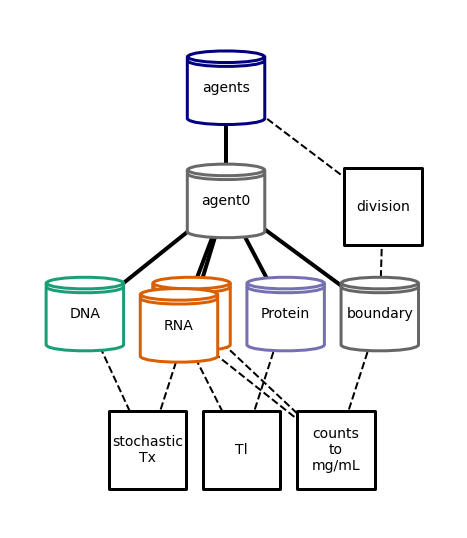

In [26]:
fig = plot_topology(
    txtl_composite, 
    filename='hierarchy_topology.pdf', 
    **hierarchy_topology_plot_config)

### plot hierarchy topology after division

In [27]:
# initial state
initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}

# make a copy of the composite
txtl_composite1 = copy.deepcopy(txtl_composite)

# make the experiment
settings = {}
hierarchy_experiment1 = composite_in_experiment(
    composite=txtl_composite1, 
    settings=exp_settings, 
    initial_state=initial_state)

# run the experiment long enough to divide
hierarchy_experiment1.update(2000)


Experiment ID: hierarchy_experiment
Created: 03/12/2021 at 12:10:25
Completed in 4.32 seconds


Writing out/hierarchy_topology_2.pdf


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


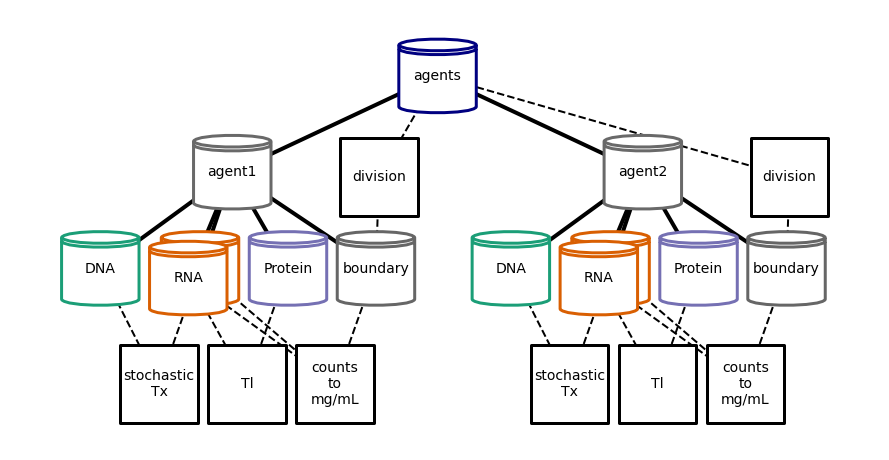

In [28]:
fig = plot_topology(
    txtl_composite1, 
    filename='hierarchy_topology_2.pdf', 
    **hierarchy_topology_plot_config2)

### run hierarchy experiment

In [29]:
# initial state
initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}

# make the experiment
settings = {}
hierarchy_experiment = composite_in_experiment(
    composite=txtl_composite, 
    settings=exp_settings, 
    initial_state=initial_state)

# run the experiment
hierarchy_experiment.update(6000)


Experiment ID: hierarchy_experiment
Created: 03/12/2021 at 12:10:30
Completed in 82.20 seconds


In [30]:
# retrieve the data
hierarchy_data = hierarchy_experiment.emitter.get_data_unitless()
path_ts = hierarchy_experiment.emitter.get_path_timeseries()

# add agent colors
paths = list(path_ts.keys())
agent_ids = set([path[1] for path in paths])
agent_colors = {
    agent_id: 'cornflowerblue' if all(e == agent_id[0] for e in agent_id) 
    else 'dimgray' 
    for agent_id in agent_ids}
hierarchy_plot_settings.update({'agent_colors': agent_colors})


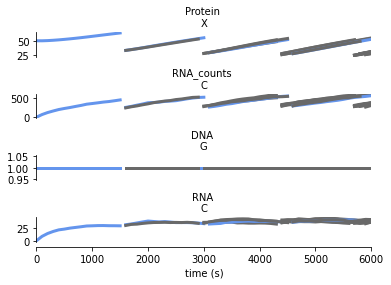

In [31]:
# make plot
multigen_fig = plot_agents_multigen(hierarchy_data, hierarchy_plot_settings)

### Colony-level metrics

In [32]:
gd_timeseries = hierarchy_experiment.emitter.get_timeseries()
colony_series = gd_timeseries['global'][('volume', 'femtoliter')]
time_vec = gd_timeseries['time']

In [33]:
# get the RNA_counts axis, to replace with colony volume
allaxes = multigen_fig.get_axes()
ax = None
for axis in allaxes:
    if axis.get_title() == 'RNA \nC':
        ax = axis

Writing out/growth_division_output.pdf


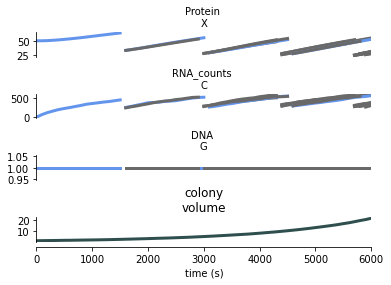

In [34]:
# multigen_fig
ax.clear()
ax.plot(time_vec, colony_series, linewidth=3.0, color='darkslategray')
ax.set_xlim([time_vec[0], time_vec[-1]])
ax.set_title('colony\nvolume', rotation=0)
ax.set_xlabel('time (s)')
ax.spines['bottom'].set_position(('axes', -0.2))
save_fig_to_dir(multigen_fig, 'growth_division_output.pdf')
multigen_fig